# Lựa chọn feature


In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy.stats import norm
k_fold = 10
seed = 42
np.random.seed(seed)

## 1. Load data


In [2]:
matches_df = pd.read_csv("../../../feature_engineering_data/arsenal.csv")

# Chọn các feature cần thiết
matches_df = matches_df[
    [
        "result",
        "venue",
        "win_before_team1",
        "win_before_team2",
        "draw_before_team2",
        "lose_before_team1",
        "lose_before_team2",
        "opponent",
        "history_team1_win_team2",
        "history_team1_draw_team2",
        "history_team1_lose_team2",
        "is_opponent_big6",
    ]
]

# Cross Validation
cv_info = {
    "n_splits": k_fold,
    "shuffle": True,
    "random_state": seed,
}

kfold_cv = KFold(**cv_info)
stratify_cv = StratifiedKFold(**cv_info)
repeated_stratify_cv = RepeatedStratifiedKFold(n_splits=k_fold, n_repeats=3, random_state=seed)

applied_cv = repeated_stratify_cv

In [3]:
matches_df.shape

(875, 12)

In [4]:
matches_df["result"].value_counts()

result
W    496
D    200
L    179
Name: count, dtype: int64

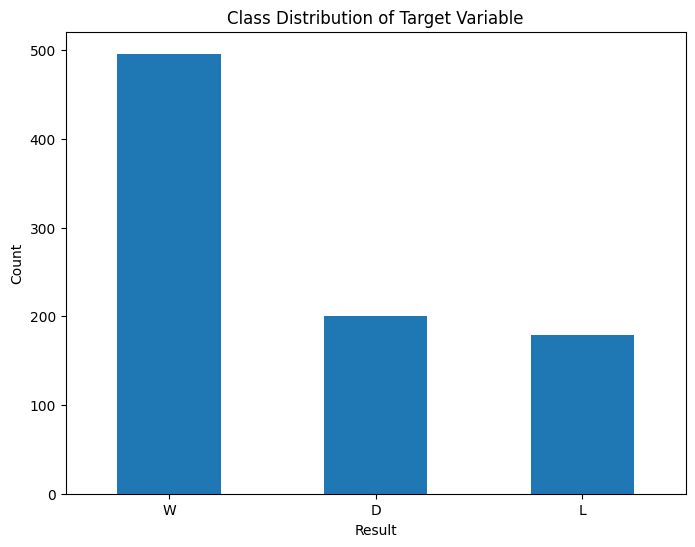

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


X = matches_df.drop("result", axis=1)
y = matches_df["result"]

# Plotting using Matplotlib
plt.figure(figsize=(8, 6))
y.value_counts().plot(kind='bar')
plt.title('Class Distribution of Target Variable')
plt.xlabel('Result')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-labels by 45 degrees
plt.show()

## 2. Dùng mô hình để lựa chọn feature


- Tách features và target variable 

In [4]:
X = matches_df.drop("result", axis=1)
y = matches_df["result"]

# Xác định các cột số (numerical) và danh mục (categorical)
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns

numerical_cols, categorical_cols

(Index(['win_before_team1', 'win_before_team2', 'draw_before_team2',
        'lose_before_team1', 'lose_before_team2', 'history_team1_win_team2',
        'history_team1_draw_team2', 'history_team1_lose_team2',
        'is_opponent_big6'],
       dtype='object'),
 Index(['venue', 'opponent'], dtype='object'))

### Tiền xử lý dữ liệu

In [5]:
# Tạo ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [7]:
X_preprocessed = preprocessor.fit_transform(X)

In [8]:
encoded_categorical_cols = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)


In [9]:
# Lấy tên cột phân loại từ OneHotEncoder
encoded_categorical_cols

array(['venue_Away', 'venue_Home', 'opponent_Aston Villa',
       'opponent_Birmingham City', 'opponent_Blackburn Rovers',
       'opponent_Blackpool', 'opponent_Bolton Wanderers',
       'opponent_Bournemouth', 'opponent_Bradford City',
       'opponent_Brentford', 'opponent_Brighton and Hove Albion',
       'opponent_Burnley', 'opponent_Cardiff City',
       'opponent_Charlton Athletic', 'opponent_Chelsea',
       'opponent_Coventry City', 'opponent_Crystal Palace',
       'opponent_Derby County', 'opponent_Everton', 'opponent_Fulham',
       'opponent_Huddersfield Town', 'opponent_Hull City',
       'opponent_Ipswich Town', 'opponent_Leeds United',
       'opponent_Leicester City', 'opponent_Liverpool',
       'opponent_Manchester City', 'opponent_Manchester United',
       'opponent_Middlesbrough', 'opponent_Newcastle United',
       'opponent_Norwich City', 'opponent_Nottingham Forest',
       'opponent_Portsmouth', 'opponent_Queens Park Rangers',
       'opponent_Reading', 'oppon

In [10]:
len(encoded_categorical_cols)

46

In [11]:
# Tạo danh sách tên cột cho DataFrame sau tiền xử lý
final_columns = numerical_cols.tolist() + encoded_categorical_cols.tolist()

In [12]:
final_columns

['win_before_team1',
 'win_before_team2',
 'draw_before_team2',
 'lose_before_team1',
 'lose_before_team2',
 'history_team1_win_team2',
 'history_team1_draw_team2',
 'history_team1_lose_team2',
 'is_opponent_big6',
 'venue_Away',
 'venue_Home',
 'opponent_Aston Villa',
 'opponent_Birmingham City',
 'opponent_Blackburn Rovers',
 'opponent_Blackpool',
 'opponent_Bolton Wanderers',
 'opponent_Bournemouth',
 'opponent_Bradford City',
 'opponent_Brentford',
 'opponent_Brighton and Hove Albion',
 'opponent_Burnley',
 'opponent_Cardiff City',
 'opponent_Charlton Athletic',
 'opponent_Chelsea',
 'opponent_Coventry City',
 'opponent_Crystal Palace',
 'opponent_Derby County',
 'opponent_Everton',
 'opponent_Fulham',
 'opponent_Huddersfield Town',
 'opponent_Hull City',
 'opponent_Ipswich Town',
 'opponent_Leeds United',
 'opponent_Leicester City',
 'opponent_Liverpool',
 'opponent_Manchester City',
 'opponent_Manchester United',
 'opponent_Middlesbrough',
 'opponent_Newcastle United',
 'opponent

In [13]:
X_preprocessed_df = pd.DataFrame.sparse.from_spmatrix(X_preprocessed, columns=final_columns)

In [14]:
X_preprocessed_df.head()

,win_before_team1,win_before_team2,draw_before_team2,lose_before_team1,lose_before_team2,history_team1_win_team2,history_team1_draw_team2,history_team1_lose_team2,is_opponent_big6,venue_Away,...,opponent_Southampton,opponent_Stoke City,opponent_Sunderland,opponent_Swansea City,opponent_Tottenham Hotspur,opponent_Watford,opponent_West Bromwich Albion,opponent_West Ham United,opponent_Wigan Athletic,opponent_Wolverhampton Wanderers
0,-2.163616,-1.36239,-1.200677,-0.980361,-1.43544,-2.254012,-1.279594,-1.045951,-0.59539,1.0,...,0,0,1.0,0,0,0,0,0,0,0
1,-2.163616,2.376723,-1.200677,3.828923,-1.43544,-2.254012,-1.279594,-1.045951,1.679572,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.186972,0.507166,-1.200677,1.424281,0.54004,-2.254012,-1.279594,-1.045951,-0.59539,0,...,0,0,0,0,0,0,0,0,0,0
3,0.47191,-0.116019,0.426005,0.622734,-0.118454,-2.254012,-1.279594,-1.045951,1.679572,1.0,...,0,0,0,0,0,0,0,0,0,0
4,-0.186972,-0.427612,0.019334,0.22196,0.54004,-2.254012,-1.279594,-1.045951,-0.59539,1.0,...,0,0,0,0,0,0,0,0,0,0


### So sánh phân bổ của dữ liệu trước và sau khi chuẩn hóa

Text(0, 0.5, 'Count')

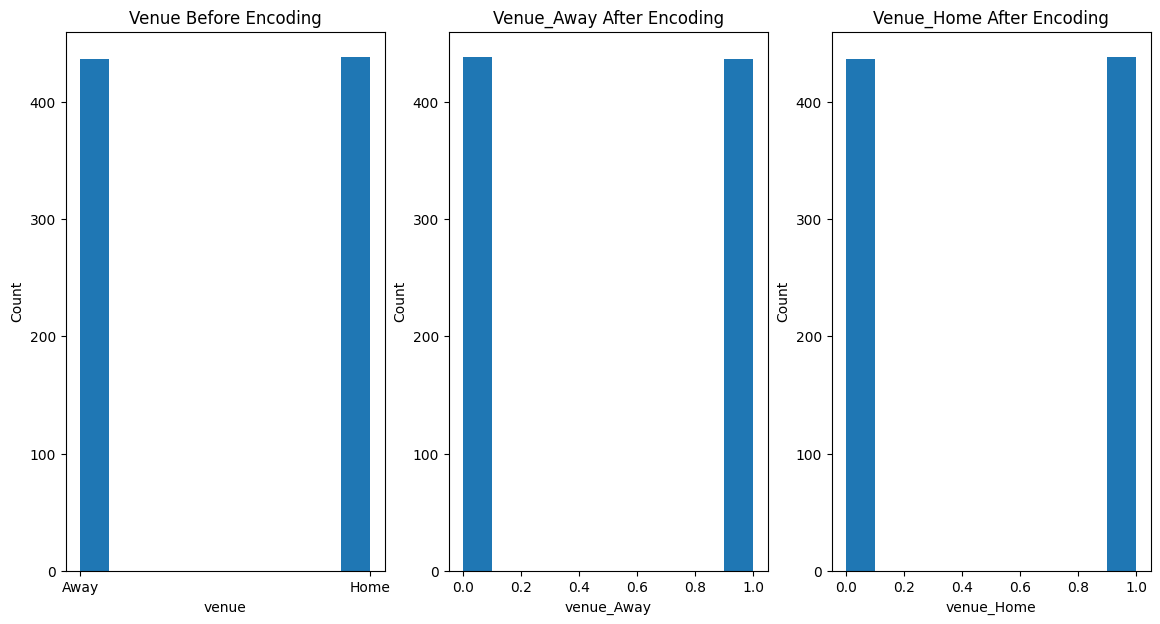

In [15]:
plt.figure(figsize=(14, 7))  # Adjust figsize as needed

plt.subplot(1, 3, 1)  # 1 row, 2 columns, subplot 1
plt.hist(matches_df['venue']);
plt.title('Venue Before Encoding')
plt.xlabel('venue')
plt.ylabel('Count')

plt.subplot(1, 3, 2)  # 1 row, 2 columns, subplot 2
plt.hist(X_preprocessed_df['venue_Away']);
plt.title('Venue_Away After Encoding')
plt.xlabel('venue_Away')
plt.ylabel('Count')

plt.subplot(1, 3, 3)  # 1 row, 2 columns, subplot 2
plt.hist(X_preprocessed_df['venue_Home']);
plt.title('Venue_Home After Encoding')
plt.xlabel('venue_Home')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

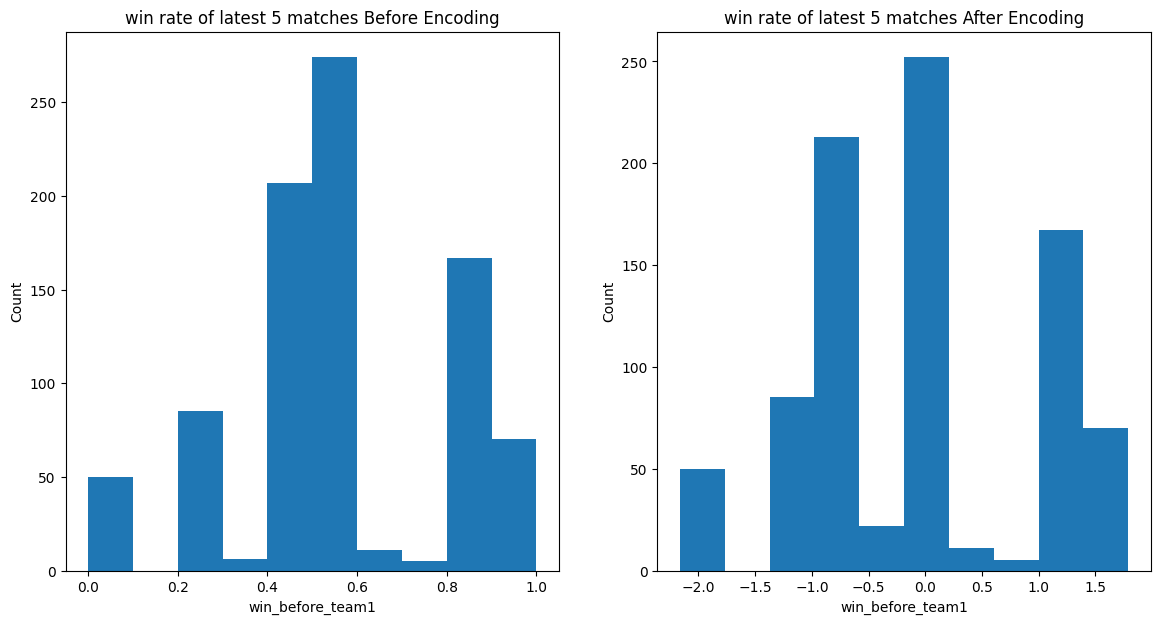

In [17]:
plt.figure(figsize=(14, 7))  # Adjust figsize as needed

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.hist(matches_df['win_before_team1']);
plt.title('win rate of latest 5 matches Before Encoding')
plt.xlabel('win_before_team1')
plt.ylabel('Count')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.hist(X_preprocessed_df['win_before_team1']);
plt.title('win rate of latest 5 matches After Encoding')
plt.xlabel('win_before_team1')
plt.ylabel('Count')

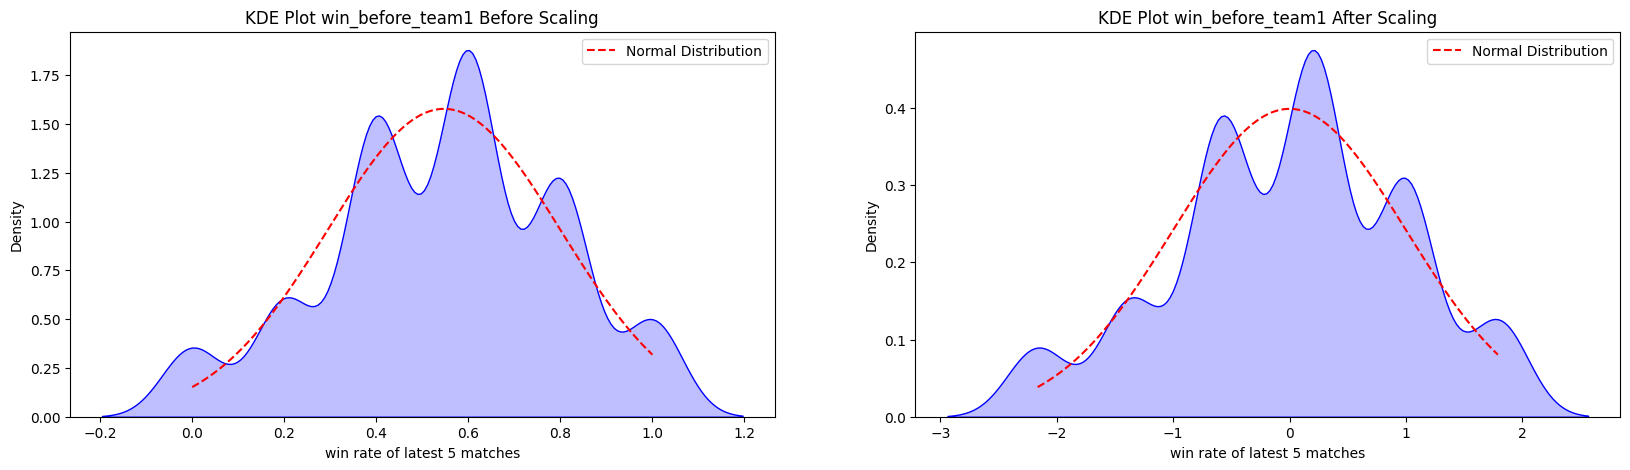

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
sns.kdeplot(matches_df['win_before_team1'], shade=True, ax = ax1, color ='b')
# Plot standard normal distribution (mu=0, sigma=1)
x = np.linspace(matches_df['win_before_team1'].min(), matches_df['win_before_team1'].max(), 1000)
normal_distribution = norm.pdf(x, np.mean(matches_df['win_before_team1']), np.std(matches_df['win_before_team1']))
ax1.plot(x, normal_distribution, color='red', linestyle='--', label='Normal Distribution')
ax1.set_title('KDE Plot win_before_team1 Before Scaling')
ax1.set_xlabel('win rate of latest 5 matches')
ax1.legend()

sns.kdeplot(X_preprocessed_df['win_before_team1'], shade=True, ax = ax2, color ='b')
# Plot standard normal distribution (mu=0, sigma=1)
x2 = np.linspace(X_preprocessed_df['win_before_team1'].min(), X_preprocessed_df['win_before_team1'].max(), 1000)
normal_distribution_2 = norm.pdf(x2, 0, 1)
ax2.plot(x2, normal_distribution_2, color='red', linestyle='--', label='Normal Distribution')
ax2.set_title('KDE Plot win_before_team1 After Scaling')
ax2.set_xlabel('win rate of latest 5 matches')
ax2.legend()

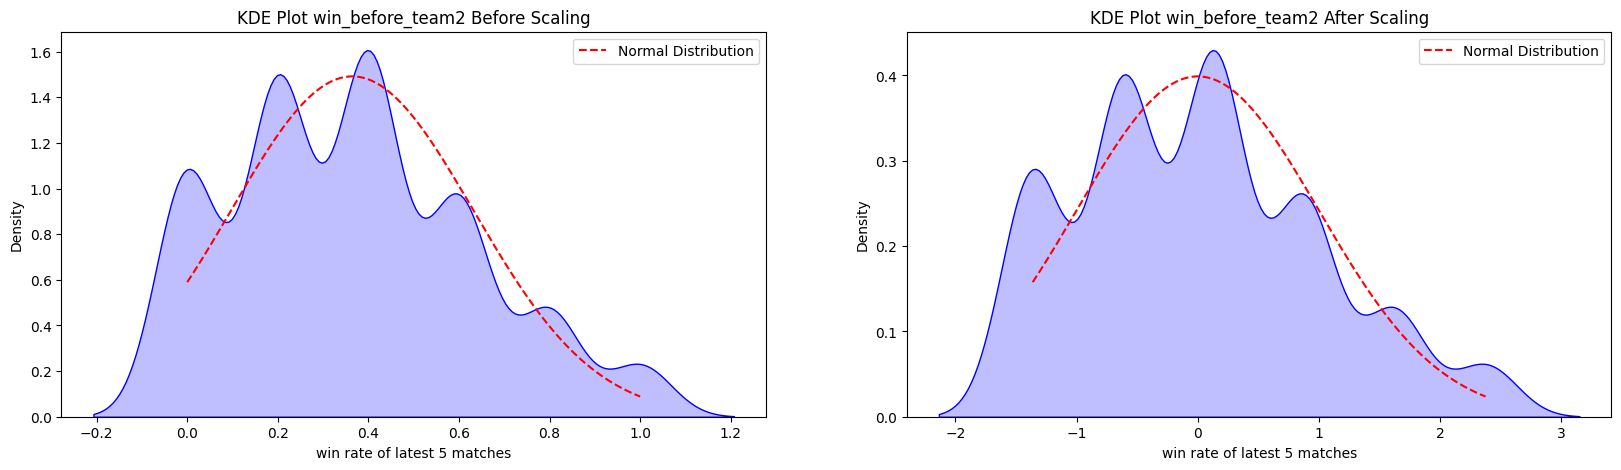

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
sns.kdeplot(matches_df['win_before_team2'], shade=True, ax = ax1, color ='b')
# Plot standard normal distribution (mu=0, sigma=1)
x = np.linspace(matches_df['win_before_team2'].min(), matches_df['win_before_team2'].max(), 1000)
normal_distribution = norm.pdf(x, np.mean(matches_df['win_before_team2']), np.std(matches_df['win_before_team2']))
ax1.plot(x, normal_distribution, color='red', linestyle='--', label='Normal Distribution')
ax1.set_title('KDE Plot win_before_team2 Before Scaling')
ax1.set_xlabel('win rate of latest 5 matches')
ax1.legend()

sns.kdeplot(X_preprocessed_df['win_before_team2'], shade=True, ax = ax2, color ='b')
# Plot standard normal distribution (mu=0, sigma=1)
x2 = np.linspace(X_preprocessed_df['win_before_team2'].min(), X_preprocessed_df['win_before_team2'].max(), 1000)
normal_distribution_2 = norm.pdf(x2, 0, 1)
ax2.plot(x2, normal_distribution_2, color='red', linestyle='--', label='Normal Distribution')
ax2.set_title('KDE Plot win_before_team2 After Scaling')
ax2.set_xlabel('win rate of latest 5 matches')
ax2.legend()

- mean và std trước chuẩn hóa

In [18]:
print('win_before_team1 Before Scaling')
print("Trung bình:", np.mean(matches_df['win_before_team1']))
print("Độ lệch chuẩn:", np.std(matches_df['win_before_team1']))

win_before_team1 Before Scaling
Trung bình: 0.5472952380952381
Độ lệch chuẩn: 0.2529539486468919


- mean và std sau chuẩn hóa

In [19]:
X_preprocessed_df['win_before_team1'] = X_preprocessed_df['win_before_team1'].astype('float64')
print('win_before_team1 After Scaling')
print("Trung bình:", np.mean(X_preprocessed_df['win_before_team1']))
print("Độ lệch chuẩn:", np.std(X_preprocessed_df['win_before_team1']))

win_before_team1 After Scaling
Trung bình: 1.786507449911109e-16
Độ lệch chuẩn: 1.0


### Định nghĩa Pipelines


In [20]:
# Định nghĩa các mô hình cơ bản
logit = LogisticRegression(random_state=seed)

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=seed,
)

svc = LinearSVC(
    C=0.05,
    penalty="l1",
    dual=False,
    random_state=seed,
)

# Tạo các pipelines kết hợp preprocessor và mô hình
pipe_rf_without_fs = Pipeline([("preprocessor", preprocessor), ("classifier", logit)])

pipe_svc_without_fs = Pipeline([("preprocessor", preprocessor), ("classifier", logit)])

pipe_rf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("feature_selection", SelectFromModel(rf)),
        ("classifier", logit),
    ]
)

pipe_svc = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("feature_selection", SelectFromModel(svc)),
        ("classifier", logit),
    ]
)

### Huấn luyện và đánh giá các Pipelines


In [8]:
# Huấn luyện và đánh giá pipeline sử dụng RandomForest
scores_rf_without_fs = cross_val_score(
    pipe_rf_without_fs,
    X,
    y,
    cv=KFold(
        n_splits=k_fold,
        shuffle=True,
        random_state=seed,
    ),
    scoring="accuracy",
    error_score="raise",
)

scores_rf = cross_val_score(
    pipe_rf,
    X,
    y,
    cv=KFold(
        n_splits=k_fold,
        shuffle=True,
        random_state=seed,
    ),
    scoring="accuracy",
    error_score="raise",
)

# Huấn luyện và đánh giá pipeline sử dụng SVC
scores_svc_without_fs = cross_val_score(
    pipe_svc_without_fs,
    X,
    y,
    cv=KFold(
        n_splits=k_fold,
        shuffle=True,
        random_state=seed,
    ),
    scoring="accuracy",
    error_score="raise",
)

scores_svc = cross_val_score(
    pipe_svc,
    X,
    y,
    cv=KFold(
        n_splits=k_fold,
        shuffle=True,
        random_state=seed,
    ),
    scoring="accuracy",
    error_score="raise",
)

In [9]:
print("Độ chính xác trung bình của RandomForest pipeline không sử dụng feature selection:", scores_rf_without_fs.mean())
print( "Độ chính xác trung bình của RandomForest pipeline có sử dụng feature selection:", scores_rf.mean())
print("Độ chính xác trung bình của SVC pipeline không sử dụng feature selection:", scores_svc_without_fs.mean())
print("Độ chính xác trung bình của SVC pipeline có sử dụng feature selection:", scores_svc.mean())

Độ chính xác trung bình của RandomForest pipeline không sử dụng feature selection: 0.5691614420062695
Độ chính xác trung bình của RandomForest pipeline có sử dụng feature selection: 0.5954022988505747
Độ chính xác trung bình của SVC pipeline không sử dụng feature selection: 0.5691614420062695
Độ chính xác trung bình của SVC pipeline có sử dụng feature selection: 0.5908568443051202


### Thử nghiệm khi dùng cách chia fold khác (như RepeatedStratifiedKFold)

In [10]:
# Huấn luyện và đánh giá pipeline sử dụng RandomForest
scores_rf_without_fs = cross_val_score(
    pipe_rf_without_fs,
    X,
    y,
    cv=applied_cv,
    scoring="accuracy",
    error_score="raise",
)

scores_rf = cross_val_score(
    pipe_rf,
    X,
    y,
    cv=applied_cv,
    scoring="accuracy",
    error_score="raise",
)

# Huấn luyện và đánh giá pipeline sử dụng SVC
scores_svc_without_fs = cross_val_score(
    pipe_svc_without_fs,
    X,
    y,
    cv=applied_cv,
    scoring="accuracy",
    error_score="raise",
)

scores_svc = cross_val_score(
    pipe_svc,
    X,
    y,
    cv=applied_cv,
    scoring="accuracy",
    error_score="raise",
)

print(
    "Độ chính xác trung bình của RandomForest pipeline không sử dụng feature selection:",
    scores_rf_without_fs.mean(),
)
print(
    "Độ chính xác trung bình của RandomForest pipeline có sử dụng feature selection:",
    scores_rf.mean(),
)
print(
    "Độ chính xác trung bình của SVC pipeline không sử dụng feature selection:",
    scores_svc_without_fs.mean(),
)
print(
    "Độ chính xác trung bình của SVC pipeline có sử dụng feature selection:",
    scores_svc.mean(),
)

Độ chính xác trung bình của RandomForest pipeline không sử dụng feature selection: 0.5679641239986067
Độ chính xác trung bình của RandomForest pipeline có sử dụng feature selection: 0.596913096482062
Độ chính xác trung bình của SVC pipeline không sử dụng feature selection: 0.5679641239986067
Độ chính xác trung bình của SVC pipeline có sử dụng feature selection: 0.5908176593521421


#### Hàm dùng để làm sạch tên feature sau bước encode

In [21]:
def clean_feature_names(feature_names):
    cleaned_names = set()  # Sử dụng set để tránh trùng lặp
    for name in feature_names:
        # Phân tách tên dựa trên tiền tố '__'
        parts = name.split("__")
        if len(parts) > 1:
            prefix = parts[0]
            base_name = parts[1]
            if prefix == "num":
                # Nếu tiền tố là 'num__', giữ nguyên base_name
                cleaned_names.add(base_name)
            elif "date_time" in base_name:
                # Đối với 'date_time', chỉ giữ 'date_time'
                cleaned_names.add("date_time")
            elif "formation_team1" in base_name:
                # Đối với 'team', chỉ giữ 'team'
                cleaned_names.add("formation_team1")
            elif "formation_team2" in base_name:
                # Đối với 'team', chỉ giữ 'team'
                cleaned_names.add("formation_team2")
            elif "_" in base_name:
                # Vd opponent_Arsenal thì cần giữ lại cả opponent_Arsenal
                cleaned_names.add(base_name)
            else:
                cleaned_names.add(base_name)
        else:
            # Không có tiền tố, giữ nguyên tên
            cleaned_names.add(name)
    return list(cleaned_names)

#### Hàm xác định danh sách feature được chọn bằng Model Selection kết hợp cross validation

In [22]:
def find_best_list_features(estimator, n_splits=k_fold):
    kf = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=seed,
    )

    best_accuracy = 0
    best_features = None

    results = []
    accuracy_mean = 0
    loop_idx = 1

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, y_train)
        accuracy = estimator.score(X_test, y_test)
        accuracy_mean += accuracy

        print(f"Accuracy at loop {loop_idx}: {accuracy}")
        loop_idx += 1
        transformed_feature_names = estimator.named_steps[
            "preprocessor"
        ].get_feature_names_out()
        best_features_in_this_loop = estimator.named_steps[
            "feature_selection"
        ].get_support()

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = best_features_in_this_loop

        results.append(
            {
                "feature_names": transformed_feature_names,
                "best_features": clean_feature_names(
                    transformed_feature_names[best_features_in_this_loop]
                ),
            }
        )

    accuracy_mean /= n_splits
    print(f"Accuracy mean: {accuracy_mean}")
    print(
        "=> Best features with max accuracy: \n",
        "\n".join(
            str(feature)
            for feature in sorted(
                clean_feature_names(transformed_feature_names[best_features])
            )
        ),
        sep="",
    )

    return results

In [13]:
rf_list_best_features = find_best_list_features(pipe_rf)

Accuracy at loop 1: 0.5454545454545454
Accuracy at loop 2: 0.5681818181818182
Accuracy at loop 3: 0.6022727272727273
Accuracy at loop 4: 0.6704545454545454
Accuracy at loop 5: 0.6136363636363636
Accuracy at loop 6: 0.6551724137931034
Accuracy at loop 7: 0.5517241379310345
Accuracy at loop 8: 0.6091954022988506
Accuracy at loop 9: 0.5172413793103449
Accuracy at loop 10: 0.6206896551724138
Accuracy mean: 0.5954022988505748
=> Best features with max accuracy: 
draw_before_team2
history_team1_draw_team2
history_team1_lose_team2
history_team1_win_team2
is_opponent_big6
lose_before_team1
lose_before_team2
venue_Away
venue_Home
win_before_team1
win_before_team2


In [14]:
[print(result["best_features"]) for result in rf_list_best_features];

['win_before_team2', 'win_before_team1', 'lose_before_team1', 'history_team1_draw_team2', 'lose_before_team2', 'is_opponent_big6', 'venue_Home', 'history_team1_lose_team2', 'draw_before_team2', 'venue_Away', 'history_team1_win_team2']
['win_before_team2', 'win_before_team1', 'lose_before_team1', 'history_team1_draw_team2', 'lose_before_team2', 'is_opponent_big6', 'venue_Home', 'history_team1_lose_team2', 'draw_before_team2', 'venue_Away', 'history_team1_win_team2']
['win_before_team2', 'win_before_team1', 'lose_before_team1', 'history_team1_draw_team2', 'lose_before_team2', 'is_opponent_big6', 'venue_Home', 'history_team1_lose_team2', 'draw_before_team2', 'venue_Away', 'history_team1_win_team2']
['win_before_team2', 'win_before_team1', 'lose_before_team1', 'history_team1_draw_team2', 'lose_before_team2', 'is_opponent_big6', 'venue_Home', 'history_team1_lose_team2', 'draw_before_team2', 'venue_Away', 'history_team1_win_team2']
['win_before_team2', 'win_before_team1', 'lose_before_team1'

In [15]:
svc_list_best_features = find_best_list_features(pipe_svc)

Accuracy at loop 1: 0.5340909090909091
Accuracy at loop 2: 0.5681818181818182
Accuracy at loop 3: 0.5909090909090909
Accuracy at loop 4: 0.6477272727272727
Accuracy at loop 5: 0.6136363636363636
Accuracy at loop 6: 0.6551724137931034
Accuracy at loop 7: 0.5517241379310345
Accuracy at loop 8: 0.6091954022988506
Accuracy at loop 9: 0.5172413793103449
Accuracy at loop 10: 0.6206896551724138
Accuracy mean: 0.5908568443051203
=> Best features with max accuracy: 
draw_before_team2
history_team1_lose_team2
history_team1_win_team2
is_opponent_big6
lose_before_team1
lose_before_team2
venue_Away
venue_Home
win_before_team1
win_before_team2


In [16]:
[print(result["best_features"]) for result in svc_list_best_features];

['win_before_team2', 'win_before_team1', 'lose_before_team1', 'opponent_Southampton', 'lose_before_team2', 'is_opponent_big6', 'venue_Home', 'history_team1_lose_team2', 'draw_before_team2', 'venue_Away']
['win_before_team2', 'win_before_team1', 'lose_before_team1', 'history_team1_draw_team2', 'opponent_Southampton', 'lose_before_team2', 'is_opponent_big6', 'venue_Home', 'history_team1_lose_team2', 'draw_before_team2', 'venue_Away']
['win_before_team2', 'win_before_team1', 'lose_before_team1', 'history_team1_draw_team2', 'opponent_Southampton', 'lose_before_team2', 'is_opponent_big6', 'venue_Home', 'history_team1_lose_team2', 'draw_before_team2', 'venue_Away']
['win_before_team2', 'win_before_team1', 'lose_before_team1', 'history_team1_draw_team2', 'opponent_Tottenham Hotspur', 'lose_before_team2', 'is_opponent_big6', 'venue_Home', 'history_team1_lose_team2', 'draw_before_team2', 'venue_Away', 'history_team1_win_team2']
['win_before_team2', 'win_before_team1', 'lose_before_team1', 'hist

In [17]:
def show_list_features_removed(list_features):
    features_not_in_list = [
        feature for feature in X.columns if feature not in list_features
    ]
    
    # In ra các đặc trưng không có trong danh sách
    print("Features bị loại bỏ:", features_not_in_list)

### Thử nghiệm lại với các cột đã chọn


In [18]:
transformed_X = preprocessor.fit_transform(X).toarray()
new_columns = numerical_cols.to_list() + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
)

transformed_X = pd.DataFrame(transformed_X, columns=new_columns)
transformed_X

,win_before_team1,win_before_team2,draw_before_team2,lose_before_team1,lose_before_team2,history_team1_win_team2,history_team1_draw_team2,history_team1_lose_team2,is_opponent_big6,venue_Away,...,opponent_Southampton,opponent_Stoke City,opponent_Sunderland,opponent_Swansea City,opponent_Tottenham Hotspur,opponent_Watford,opponent_West Bromwich Albion,opponent_West Ham United,opponent_Wigan Athletic,opponent_Wolverhampton Wanderers
0,-2.163616,-1.362390,-1.200677,-0.980361,-1.435440,-2.254012,-1.279594,-1.045951,-0.595390,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.163616,2.376723,-1.200677,3.828923,-1.435440,-2.254012,-1.279594,-1.045951,1.679572,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.186972,0.507166,-1.200677,1.424281,0.540040,-2.254012,-1.279594,-1.045951,-0.595390,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.471910,-0.116019,0.426005,0.622734,-0.118454,-2.254012,-1.279594,-1.045951,1.679572,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.186972,-0.427612,0.019334,0.221960,0.540040,-2.254012,-1.279594,-1.045951,-0.595390,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,-1.372958,-1.362390,-0.224668,-0.018504,1.725328,-0.983496,0.436062,1.338160,1.679572,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
871,-1.372958,1.628900,-1.200677,-0.018504,-0.645248,0.435321,-0.069070,-0.276331,-0.595390,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872,-0.582301,0.881078,-1.200677,-0.018504,0.144944,-0.768993,0.224390,1.248916,-0.595390,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873,-0.582301,0.133255,-0.224668,0.943353,0.144944,1.829791,-1.279594,-1.045951,-0.595390,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tạo ra một hàm để đánh giá accuracy của mô hình trên danh sách các đặc trưng đã chọn

In [23]:
def evaluate_selected_features(model_name, model_list_best_features, evaluate_func):
    max_score = 0
    list_best_features = []
    unique_list = set()
    loop_index = 0

    for index, best_features in enumerate(model_list_best_features):
        cleaned_features_svc = best_features["best_features"]
        score = evaluate_func(cleaned_features_svc)
        if score == max_score:
            temp = tuple(cleaned_features_svc)
            if temp not in unique_list:
                unique_list.add(temp)
                list_best_features.append(cleaned_features_svc)
        elif score > max_score:
            loop_index = index
            max_score = score
            list_best_features = [cleaned_features_svc]
            unique_list.clear()
            unique_list.add(tuple(cleaned_features_svc))

    print(f"Accuracy max: {max_score} at loop: {loop_index}")

    print(f"List best features of: {model_name}")
    print(list_best_features)

    for best_features in list_best_features:
        show_list_features_removed(best_features)

    print("\nRaw features: ")
    print(
        "\n".join(
            str(feature)
            for feature in sorted(model_list_best_features[loop_index]["best_features"])
        )
    )

### 1. Random Forest

In [20]:
idx = 0
def evaluate_rf(cleaned_features) -> int:
    global idx
    X_new = transformed_X[cleaned_features]

    logistic_model = LogisticRegression(random_state=seed)
    scores_rf = cross_val_score(
        logistic_model,
        X_new,
        y,
        cv=applied_cv,
        scoring="accuracy",
        error_score="raise",
    )

    print("Loop:", idx)
    idx += 1
    print(scores_rf)
    print("Score mean:", scores_rf.mean())
    print("==========================================================================")
    return scores_rf.mean()

In [21]:
evaluate_selected_features("Random forest", rf_list_best_features, evaluate_rf)

Loop: 0
[0.57954545 0.60227273 0.61363636 0.61363636 0.56818182 0.5862069
 0.6091954  0.59770115 0.59770115 0.5862069  0.57954545 0.625
 0.63636364 0.64772727 0.57954545 0.55172414 0.55172414 0.5862069
 0.62068966 0.5862069  0.57954545 0.60227273 0.60227273 0.625
 0.60227273 0.65517241 0.6091954  0.55172414 0.56321839 0.59770115]
Score mean: 0.596913096482062
Loop: 1
[0.57954545 0.60227273 0.61363636 0.61363636 0.56818182 0.5862069
 0.6091954  0.59770115 0.59770115 0.5862069  0.57954545 0.625
 0.63636364 0.64772727 0.57954545 0.55172414 0.55172414 0.5862069
 0.62068966 0.5862069  0.57954545 0.60227273 0.60227273 0.625
 0.60227273 0.65517241 0.6091954  0.55172414 0.56321839 0.59770115]
Score mean: 0.596913096482062
Loop: 2
[0.57954545 0.60227273 0.61363636 0.61363636 0.56818182 0.5862069
 0.6091954  0.59770115 0.59770115 0.5862069  0.57954545 0.625
 0.63636364 0.64772727 0.57954545 0.55172414 0.55172414 0.5862069
 0.62068966 0.5862069  0.57954545 0.60227273 0.60227273 0.625
 0.60227273 

### 2. SVC

In [22]:
idx = 0
def evaluate_svc(cleaned_features) -> int:
    global idx
    X_new = transformed_X[cleaned_features]

    logistic_model = LogisticRegression(random_state=seed)
    scores_svc = cross_val_score(
        logistic_model,
        X_new,
        y,
        cv=applied_cv,
        scoring="accuracy",
        error_score="raise",
    )

    print("Loop:", idx)
    idx +=1 
    print(scores_svc)
    print("Score mean:", scores_svc.mean())
    print("==========================================================================")
    return scores_svc.mean()

In [23]:
evaluate_selected_features("SVC", svc_list_best_features, evaluate_svc)

Loop: 0
[0.56818182 0.61363636 0.625      0.59090909 0.56818182 0.5862069
 0.6091954  0.59770115 0.59770115 0.57471264 0.59090909 0.625
 0.63636364 0.64772727 0.57954545 0.54022989 0.55172414 0.56321839
 0.62068966 0.59770115 0.57954545 0.61363636 0.60227273 0.61363636
 0.56818182 0.65517241 0.62068966 0.55172414 0.56321839 0.6091954 ]
Score mean: 0.5953935910832463
Loop: 1
[0.56818182 0.60227273 0.625      0.59090909 0.56818182 0.5862069
 0.6091954  0.59770115 0.59770115 0.57471264 0.57954545 0.625
 0.63636364 0.64772727 0.57954545 0.54022989 0.55172414 0.56321839
 0.6091954  0.5862069  0.57954545 0.61363636 0.60227273 0.61363636
 0.57954545 0.65517241 0.62068966 0.55172414 0.56321839 0.6091954 ]
Score mean: 0.5942485196795543
Loop: 2
[0.56818182 0.60227273 0.625      0.59090909 0.56818182 0.5862069
 0.6091954  0.59770115 0.59770115 0.57471264 0.57954545 0.625
 0.63636364 0.64772727 0.57954545 0.54022989 0.55172414 0.56321839
 0.6091954  0.5862069  0.57954545 0.61363636 0.60227273 0.6

### Kết luận
Vậy sau bước lựa chọn feature:
- Random Forest: 
    + "result",
    + "venue",
    + "win_before_team1",
    + "win_before_team2",
    + "draw_before_team2",
    + "lose_before_team1",
    + "lose_before_team2",
    + "history_team1_win_team2",
    + "history_team1_draw_team2",
    + "history_team1_lose_team2",
    + "is_opponent_big6",
    
- SVC: danh sách đặc trưng được chọn:
    + "result",
    + "venue",
    + "history_team1_lose_team2",
    + "draw_before_team2",
    + "lose_before_team2",
    + "lose_before_team1",
    + "win_before_team2",
    + "is_opponent_big6",
    + "win_before_team1",

In [24]:
# RF sẽ bỏ opponent
data_rf = matches_df[
    [
        # "venue_Away",
        # "venue_Home",
        "result",
        "venue",
        "win_before_team1",
        "win_before_team2",
        "draw_before_team2",
        "lose_before_team1",
        "lose_before_team2",
        "history_team1_win_team2",
        "history_team1_draw_team2",
        "history_team1_lose_team2",
        "is_opponent_big6",
    ]
]


data_rf.to_csv("../../train_model/Arsenal/data_rf.csv", index=False)

In [25]:
data_svc = matches_df[
    [
        "result",
        # "venue_Away",
        # "venue_Home",
        "venue",
        "history_team1_lose_team2",
        "draw_before_team2",
        "lose_before_team2",
        "lose_before_team1",
        "win_before_team2",
        "win_before_team1",
        "is_opponent_big6",
    ]
]

data_svc.to_csv("../../train_model/Arsenal/data_svc.csv", index=False)